In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn as nn

In [ ]:
import torch.nn.functional as F
import torch.autograd as autograd
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from matplotlib.pyplot import imshow, imsave

import numpy as np
import datetime
import os, sys

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [ ]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [ ]:
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

our_data = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

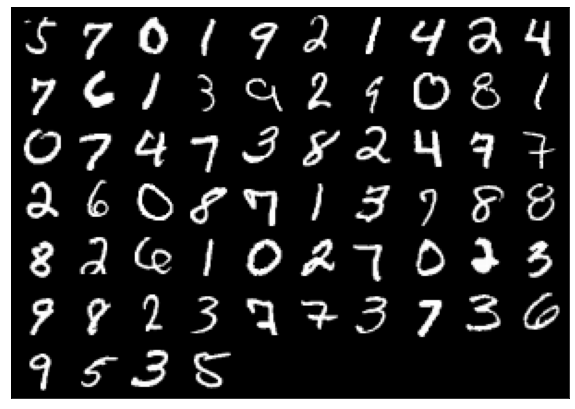

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=100):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=10).permute(1, 2, 0))

def show_batch(dl, nmax=100):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(our_data)

In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def ohc(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1)
    return c

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, in_channel=1, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.transform = nn.Sequential(
            nn.Linear(input_size+condition_size, 784),
            nn.LeakyReLU(0.2),
        )
        self.conv = nn.Sequential(

            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 1),
        )
    
    def forward(self, x, c=None):
        x, c = x.view(x.size(0), -1), c.float() 
        v = torch.cat((x, c), 1)
        y_ = self.transform(v)
        y_ = y_.view(y_.shape[0], 1, 28, 28) 
        y_ = self.conv(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [ ]:
Dis = Discriminator().to(dev)

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_size=100, condition_size=10):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size+condition_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.float()
        v = torch.cat((x, c), 1)
        y_ = self.fc(v)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_)
        return y_

In [ ]:
Gen = Generator().to(dev)

In [ ]:
D_opt = torch.optim.Adam(Dis.parameters(), lr=0.0001, betas=(0., 0.9))
G_opt = torch.optim.Adam(Gen.parameters(), lr=0.0001, betas=(0., 0.9))

D_labels = torch.ones([batch_size, 1]).to(dev) 
D_fakes = torch.zeros([batch_size, 1]).to(dev) 

In [ ]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [ ]:
def get_sample_image(Gen, n_noise=100):

    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(dev)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(dev)
        y_hat = Gen(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [ ]:
max_epoch = 25
step = 0
n_noise = 100
p_coeff = 10
n_critic = 5

MODEL_NAME = 'WGAN-gp'
gen_losses = []
dis_losses = []

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(our_data):
        Dis.zero_grad()

        x = images.to(dev)
        y = labels.view(batch_size, 1)
        y = ohc(y).to(dev)
        
        z = torch.randn(batch_size, n_noise).to(dev)
        x_fake = Gen(z, y)
                
        eps = torch.rand(batch_size, 1, 1, 1).to(dev)
        x_penalty = eps*x + (1-eps)*x_fake
        x_penalty = x_penalty.view(x_penalty.size(0), -1)
        p_outputs = Dis(x_penalty, y)
        xp_grad = autograd.grad(outputs=p_outputs, inputs=x_penalty, grad_outputs=D_labels,
                                create_graph=True, retain_graph=True, only_inputs=True)
        grad_penalty = p_coeff * torch.mean(torch.pow(torch.norm(xp_grad[0], 2, 1) - 1, 2))

        x_outputs = Dis(x, y)
        z_outputs = Dis(x_fake, y)
        D_x_loss = torch.mean(x_outputs)
        D_z_loss = torch.mean(z_outputs)
        D_loss = D_z_loss - D_x_loss + grad_penalty
        
        D_loss.backward()
        D_opt.step()      
        dis_losses += [D_loss.item()]

        if step % n_critic == 0:
            Dis.zero_grad()
            Gen.zero_grad()

            z = torch.randn(batch_size, n_noise).to(dev)
            z_outputs = Dis(Gen(z, y), y)
            G_loss = -torch.mean(z_outputs)

            G_loss.backward()
            G_opt.step()
        
        gen_losses += [G_loss.item()]
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            Gen.eval()
            img = get_sample_image(Gen, n_noise)
            imsave('samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img, cmap='gray')
            Gen.train()
        step += 1

Epoch: 0/25, Step: 0, D Loss: 9.918889045715332, G Loss: -0.01602441444993019
Epoch: 0/25, Step: 500, D Loss: -17.97752571105957, G Loss: -2.652846574783325
Epoch: 1/25, Step: 1000, D Loss: -12.08613395690918, G Loss: -5.134438514709473
Epoch: 1/25, Step: 1500, D Loss: -4.091865539550781, G Loss: -9.546792030334473
Epoch: 2/25, Step: 2000, D Loss: -3.2266018390655518, G Loss: -8.946398735046387
Epoch: 2/25, Step: 2500, D Loss: -3.628848075866699, G Loss: -2.126211643218994
Epoch: 3/25, Step: 3000, D Loss: -5.172095775604248, G Loss: -2.4149584770202637
Epoch: 3/25, Step: 3500, D Loss: -5.745398044586182, G Loss: -0.7175423502922058
Epoch: 4/25, Step: 4000, D Loss: -5.724843978881836, G Loss: -2.3764991760253906
Epoch: 4/25, Step: 4500, D Loss: -6.236538410186768, G Loss: -4.229824066162109
Epoch: 5/25, Step: 5000, D Loss: -5.129328727722168, G Loss: -5.891324043273926
Epoch: 5/25, Step: 5500, D Loss: -4.52040958404541, G Loss: -4.560678005218506
Epoch: 6/25, Step: 6000, D Loss: -4.7401

**Loss Vs Epochs**

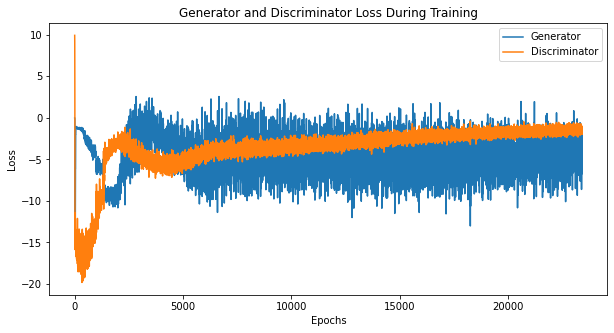

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="Generator")
plt.plot(dis_losses,label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**10 x 10 grid plot of 100 randomly generated images**

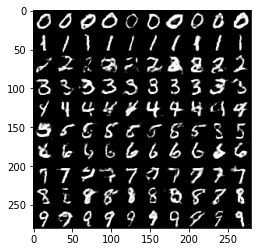

In [ ]:
Gen.eval()
imshow(get_sample_image(Gen, n_noise), cmap='gray')